In [50]:
import os
import sys

import pandas as pd
import numpy as np

In [14]:
project_home = os.path.join("../")
sys.path.append(project_home)
data_path = os.path.join(project_home, "data/merged_preprocessed.csv")

In [15]:
df = pd.read_csv(data_path, encoding="latin1")

In [ ]:
new_cols = ["state", "city", "speciality", "girl_exclusive", "student_hostel_available"]

In [ ]:
df[new_cols]

In [ ]:
df["type"].value_counts()

In [ ]:
df["discipline_group"].nunique()

# Preprocessing and EDA

In [16]:
features_for_classification = [
    "levell", "programme", "discipline_group", "type", "year", "total_general_total", "pwd_total_persons",
    "other_minority_total_persons", 'state', 'speciality', 'girl_exclusive', 'student_hostel_available'
]

Y_col = "muslim_minority_total_persons"

In [17]:
X = df[features_for_classification].copy()

In [18]:
Y = df[Y_col].copy()

In [19]:
y = Y > 0.1

In [20]:
y.value_counts()

False    328034
True      47163
Name: muslim_minority_total_persons, dtype: int64

In [21]:
X.columns

Index(['levell', 'programme', 'discipline_group', 'type', 'year',
       'total_general_total', 'pwd_total_persons',
       'other_minority_total_persons', 'state', 'speciality', 'girl_exclusive',
       'student_hostel_available'],
      dtype='object')

In [22]:
import category_encoders as ce

In [23]:
ce_ord = ce.BinaryEncoder(cols = ['levell', 'programme', 'discipline_group', 'type', 'state', 'speciality'])
X = ce_ord.fit_transform(X)

In [24]:
X["student_hostel_available"] = X["student_hostel_available"].apply(lambda x: 1 if x else 0)

## IGNORE the PCA and plotting for now:

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(X.values)

In [ ]:
plot_df = pd.DataFrame()
plot_df['pca-one'] = pca_result[:,0]
plot_df['pca-two'] = pca_result[:,1] 
plot_df['pca-three'] = pca_result[:,2]
plot_df["y"] = y

In [ ]:
rndperm = np.random.permutation(X.shape[0])[:10000]

In [ ]:
plt.figure(figsize=(12,6))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="y",
    palette=sns.color_palette("hls", 2),
    data=plot_df.loc[rndperm,:],
    legend="full",
    alpha=0.3
)

In [ ]:
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=plot_df.loc[rndperm,:]["pca-one"], 
    ys=plot_df.loc[rndperm,:]["pca-two"], 
    zs=plot_df.loc[rndperm,:]["pca-three"], 
    c=plot_df.loc[rndperm,:]["y"]
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

# Dataset preparation

In [25]:
X.shape

(375197, 44)

In [26]:
X = X.values

In [27]:
y = y.astype(int).values

In [28]:
y = y.reshape(375197, 1)

In [29]:
X.shape, y.shape

((375197, 44), (375197, 1))

In [30]:
def split_data(X, Y):
    shuffle = np.random.permutation(X.shape[0])
    X_test = X[shuffle[:20000], :]
    Y_test = Y[shuffle[:20000], :]
    X_dev = X[shuffle[20001:40000], :]
    Y_dev = Y[shuffle[20001:40000], :]
    X_train = X[shuffle[40000:], :]
    Y_train = Y[shuffle[40000:], :]
    
    return X_train, Y_train, X_dev, Y_dev, X_test, Y_test

In [31]:
X_train, Y_train, X_dev, Y_dev, X_test, Y_test = split_data(X, y)

In [32]:
X_train.shape, Y_train.shape

((335197, 44), (335197, 1))

## Logistic regression - own implementation

In [48]:
def sigmoid(z):
    s = 1 / (1 + np.exp(-z))
    return s

In [34]:
def initialize_with_zeros(dim):
    w = np.zeros((dim,1))
    b = 0.0
    
    return w, b

In [35]:
def propagate(w, b, X, Y):
    
    m = X.shape[1]
    A = sigmoid(np.dot(w.T,X)+b)
    cost = -1/m * np.sum(Y * np.log(A) + (1-Y) * (np.log(1-A)))
    dz= (1/m)*(A - Y)
    dw = np.dot(X,dz.T)
    db = np.sum(dz)

    cost = np.squeeze(cost)
    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

In [36]:
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    costs = []
    
    for i in range(num_iterations):
        grads, cost = propagate(w, b, X, Y)

        dw = grads["dw"]
        db = grads["db"]
        w = w - (learning_rate*dw)
        b = b - (learning_rate*db)

        if i % 100 == 0:
            costs.append(cost)
        
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

In [52]:
def predict(w, b, X):
    
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0], 1)
    A =  sigmoid(np.dot(w.T,X)+ b)
        
    Y_prediction = 1. * (A > 0.5)
    return Y_prediction

In [38]:
def model(X_train, Y_train, X_test, Y_test, num_iterations=2000, learning_rate=0.5, print_cost=False):
    w, b = initialize_with_zeros(X_train.shape[0])

    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)

    w = parameters["w"]
    b = parameters["b"]

    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)

    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

In [54]:
X_train = X_train.astype(np.float32)
Y_train = Y_train.astype(np.float32)
X_dev = X_dev.astype(np.float32)
Y_dev = Y_dev.astype(np.float32)

#### The below cell takes around 10 mins to run. The exact same results are achieved using sklearn library used for verification in the next secction of this notebook

In [56]:
%%time
d = model(X_train.T, Y_train.T, X_dev.T, Y_dev.T, num_iterations = 1000, learning_rate = 0.005, print_cost = True)

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.428206
Cost after iteration 200: 0.393272
Cost after iteration 300: 0.385039
Cost after iteration 400: 0.382260
Cost after iteration 500: 0.380927
Cost after iteration 600: 0.380041
Cost after iteration 700: 0.379316
Cost after iteration 800: 0.378664
Cost after iteration 900: 0.378054
Cost after iteration 1000: 0.377476
Cost after iteration 1100: 0.376926
Cost after iteration 1200: 0.376401
Cost after iteration 1300: 0.375899
Cost after iteration 1400: 0.375419
Cost after iteration 1500: 0.374959
Cost after iteration 1600: 0.374519
Cost after iteration 1700: 0.374098
Cost after iteration 1800: 0.373694
Cost after iteration 1900: 0.373307
train accuracy: 87.42620011515616 %
test accuracy: 87.43437171858594 %
CPU times: user 18min 31s, sys: 10min 45s, total: 29min 16s
Wall time: 7min 27s


## Logistic regression using sklearn:

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
logistic_model = LogisticRegression(verbose=1, max_iter=1000000, C=0.1).fit(
    X_train, 
    Y_train.reshape((Y_train.shape[0]),)
)

In [ ]:
logistic_model.score(X_train, Y_train)

In [ ]:
preds = logistic_model.predict(X_dev)
count=0
for idx, pred in enumerate(preds):
    if pred == Y_dev[idx]:
        count += 1
print("Dev accuracy = {}".format(count/len(preds)))

In [ ]:
preds = logistic_model.predict(X_test)
count=0
for idx, pred in enumerate(preds):
    if pred == Y_test[idx]:
        count += 1
print("Test accuracy = {}".format(count/len(preds)))

## Neural Network approach:

In [ ]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers

In [38]:
batch_size = 8
learning_rate = 0.0003
l2_lambda = 0.1
dropout_rate = 0.4
epochs= 3

In [31]:
def create_dataset(x, y, batch_size=16):
    x = x.astype(np.float32)
    y = y.astype(np.float32)
    return tf.data.Dataset.from_tensor_slices((x, y)).shuffle(y.shape[0]).batch(batch_size)

In [42]:
train_dataset = create_dataset(X_train, Y_train, batch_size)
dev_dataset = create_dataset(X_dev, Y_dev, batch_size)

In [33]:
keras.layers.Dense(units=64, activation='relu', input_dim=44, kernel_regularizer=regularizers.l2(l2_lambda)),

(<tensorflow.python.keras.layers.core.Dense at 0x7fa3c773f588>,)

In [43]:
model = keras.Sequential([
    keras.layers.Dense(units=32, activation='relu', input_dim=44, kernel_regularizer=regularizers.l2(l2_lambda)),
#     keras.layers.Dropout(rate=dropout_rate),
    keras.layers.Dense(units=8, activation='relu', kernel_regularizer=regularizers.l2(l2_lambda)),
#     keras.layers.Dropout(rate=dropout_rate),
    keras.layers.Dense(units=2, activation='softmax')
])

In [44]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [45]:
history = model.fit(
    train_dataset, 
    epochs=epochs, 
    validation_data=dev_dataset,
)

Train for 41900 steps, validate for 2500 steps
Epoch 1/3
41900/41900 [==============================] - 109s 3ms/step - loss: 3797.2675 - accuracy: 0.4035 - val_loss: 10734.1040 - val_accuracy: 0.1831
Epoch 2/3
41900/41900 [==============================] - 108s 3ms/step - loss: 23596.3658 - accuracy: 0.5072 - val_loss: 39393.9572 - val_accuracy: 0.0000e+00
Epoch 3/3
41900/41900 [==============================] - 111s 3ms/step - loss: 61025.3524 - accuracy: 0.5074 - val_loss: 85564.5628 - val_accuracy: 0.0000e+00


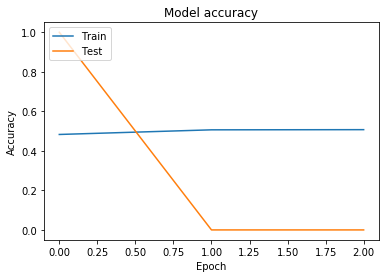

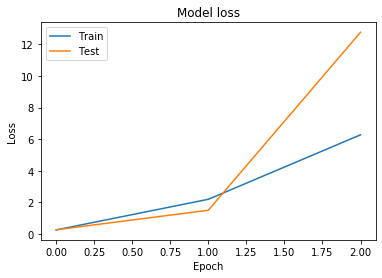

In [37]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
history.history

In [57]:
preds = model.predict(X_dev.astype(np.float32))
temp = None
c=0
for idx, pred in enumerate(preds):
    temp = np.argmax(pred)
    if temp == Y_dev[idx]:
        c += 1

print("Dev acc is {}".format(c/len(preds)))

Dev acc is 0.12215610780539027


In [58]:
preds = model.predict(X_test.astype(np.float32))
temp = None
c=0
for idx, pred in enumerate(preds):
    temp = np.argmax(pred)
    if temp == Y_test[idx]:
        c += 1

print("Dev acc is {}".format(c/len(preds)))

Dev acc is 0.12465
